In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import glob
import math
import pickle

training_data = pd.read_csv("./TrainingData.csv")

validation_data = pd.read_csv("./ValidationData.csv")

In [8]:
dataMerge = pd.concat([training_data, validation_data])

In [9]:

coulumns_dropped = [ "USERID", "PHONEID", "TIMESTAMP", "RELATIVEPOSITION","BUILDINGID"]

reordered_columns = [col for col in dataMerge.columns if col != 'BUILDINGID'] + ['BUILDINGID']
dataMerge = dataMerge[reordered_columns]

data_filtered = dataMerge[dataMerge['BUILDINGID'] == 2].drop(columns=coulumns_dropped)

print("Data Shape:", data_filtered.shape)
data_filtered.head()

Data Shape: (9760, 524)


,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP515,WAP516,WAP517,WAP518,WAP519,WAP520,LONGITUDE,LATITUDE,FLOOR,SPACEID
46,100,100,100,100,100,100,100,100,100,100,...,100,100,-93,100,100,100,-7331.748000,4.864767e+06,3,247
47,100,100,100,100,100,100,100,100,100,100,...,100,100,-89,100,100,100,-7331.400500,4.864768e+06,3,248
49,100,100,100,100,100,100,100,100,100,100,...,100,100,100,-91,100,100,-7327.492165,4.864767e+06,3,247
50,100,100,100,100,100,100,100,100,100,100,...,100,100,-90,100,100,100,-7336.700400,4.864764e+06,3,246
51,100,100,100,100,100,100,100,100,100,100,...,100,100,-92,100,100,100,-7337.394800,4.864763e+06,3,245


In [10]:
# General function for normalizing x which is in the range [xmin, xmax] to a range [a,b]

def normalize(x, xmin, xmax, a, b):
    numerator = x - xmin
    denominator = xmax - xmin
    multiplier = b - a
    ans = (numerator/denominator)*multiplier + a
    return ans

In [11]:
#Normalization for RSSI values

print(data_filtered.iloc[:, 0:520].min().min()) # -104
no_sig = 100
sig_min = -104
sig_max = 0
tar_min = 0.25
tar_max = 1.0
def normalize_wifi(num):
    ans = 0
    num = float(num)
    if math.isclose(num, no_sig, rel_tol=1e-3):  #If the RSSI value = no_signal ==> the value after normalized is 0
        return 0
    else:
        ans = normalize(num, sig_min, sig_max, tar_min, tar_max)
        return ans

-104


In [12]:
# Normalize LATITUDE,LONGITUDE,FLOOR,BUILDINGID,SPACEID and RELATIVEPOSITION
data_filtered["LATITUDE"] = data_filtered["LATITUDE"]
data_filtered["LONGITUDE"] = data_filtered["LONGITUDE"]

data_copy = data_filtered.copy()
print("===========min_training_data_copy===========")
print(data_copy.iloc[:, 0:520].min())

===========min_training_data_copy===========
WAP001    100
WAP002    100
WAP003    100
WAP004    100
WAP005    -97
         ... 
WAP516   -101
WAP517   -101
WAP518    -97
WAP519    100
WAP520    100
Length: 520, dtype: int64


In [13]:
# Normalize RSSI values
wifi_cells = data_copy.columns[:520]
print(wifi_cells)

for i in wifi_cells:
    data_copy[i] = data_copy[i].apply(normalize_wifi)

Index(['WAP001', 'WAP002', 'WAP003', 'WAP004', 'WAP005', 'WAP006', 'WAP007',
       'WAP008', 'WAP009', 'WAP010',
       ...
       'WAP511', 'WAP512', 'WAP513', 'WAP514', 'WAP515', 'WAP516', 'WAP517',
       'WAP518', 'WAP519', 'WAP520'],
      dtype='object', length=520)


In [14]:
#Split dataset of 9760 rows into two parts randomly, one part is 8269 rows for training and another part is 1464 rows for testing
from sklearn.model_selection import train_test_split

data_copy, test_data = train_test_split(data_copy, test_size=1464, random_state=42)
print("data_copy Shape:", data_copy.shape)
print("test_data Shape:", test_data.shape)
test_data.head()

data_copy Shape: (8296, 524)
test_data Shape: (1464, 524)


,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP515,WAP516,WAP517,WAP518,WAP519,WAP520,LONGITUDE,LATITUDE,FLOOR,SPACEID
7510,0,0,0,0,0.0,0.0,0,0,0,0,...,0,0.0000,0.000000,0.0,0,0,-7372.802900,4.864849e+06,2,106
14681,0,0,0,0,0.0,0.0,0,0,0,0,...,0,0.0000,0.000000,0.0,0,0,-7391.930192,4.864841e+06,1,143
644,0,0,0,0,0.0,0.0,0,0,0,0,...,0,0.0000,0.372596,0.0,0,0,-7363.038300,4.864766e+06,3,229
190,0,0,0,0,0.0,0.0,0,0,0,0,...,0,0.0000,0.430288,0.0,0,0,-7392.357000,4.864781e+06,3,216
6275,0,0,0,0,0.0,0.0,0,0,0,0,...,0,0.4375,0.423077,0.0,0,0,-7352.664769,4.864829e+06,0,124


In [15]:
X_train_all = data_copy.iloc[:, 0:520] # store the APs in X_train_all
y_train_all = data_copy.iloc[:, 522:524] #store FLOOR in y_train_all
z_train_all = data_copy.iloc[:, 520:522] #store x & y in z_train_all

X_test_all = test_data.iloc[:, 0:520] 
y_test_all = test_data.iloc[:, 522:524]
z_test_all = test_data.iloc[:, 520:522]


In [16]:
#the model for predication the floor
from keras.models import Sequential
from keras.layers import Dense,Dropout

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(520,)))  
model.add(Dense(64, activation='relu')) 
model.add(Dropout(0.5))          
model.add(Dense(5, activation='softmax'))  

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train_all, y_train_all.iloc[:, 0], epochs=20, batch_size=32, validation_split=0.2)

test_loss, test_accuracy = model.evaluate(X_test_all, y_test_all.iloc[:, 0])
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
predictions = model.predict(X_test_all)

predicted_floor_labels = np.argmax(predictions, axis=1)

for i in range(10):
    actual_floor = y_test_all.iloc[i, 0]  
    predicted_floor = predicted_floor_labels[i]  
    print("Sample {}: Actual Floor: {}, Predicted Floor: {}".format(i+1, actual_floor, predicted_floor))


C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6392 - loss: 0.9794 - val_accuracy: 0.9777 - val_loss: 0.0985
Epoch 2/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9674 - loss: 0.1338 - val_accuracy: 0.9855 - val_loss: 0.0596
Epoch 3/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9782 - loss: 0.0845 - val_accuracy: 0.9855 - val_loss: 0.0497
Epoch 4/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9840 - loss: 0.0618 - val_accuracy: 0.9898 - val_loss: 0.0415
Epoch 5/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9883 - loss: 0.0430 - val_accuracy: 0.9916 - val_loss: 0.0394
Epoch 6/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9916 - loss: 0.0341 - val_accuracy: 0.9898 - val_loss: 0.0413
Epoch 7/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9896 - loss: 0.0464 - val_accuracy: 0.9886 - val_loss: 0.0391
Epoch 8/20
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9919 - loss: 0.0346 - val_accuracy: 0.

In [17]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import numpy as np

filtered_data_floor_0 = data_copy[data_copy['FLOOR'] == 0]
print(filtered_data_floor_0.shape)

unique_Trainvalues = np.unique(filtered_data_floor_0.values[:, 523])
num_unique_Trainvalues = len(unique_Trainvalues)
print("Number of unique values for spaceid:", num_unique_Trainvalues)
print(unique_Trainvalues)

column_values =  filtered_data_floor_0.iloc[:, 523].values

label_encoder = LabelEncoder()
encoded_values = label_encoder.fit_transform(column_values)

scaler = MinMaxScaler(feature_range=(0, 44))  
mapped_values = scaler.fit_transform(encoded_values.reshape(-1, 1)).astype(int)

filtered_data_floor_0.iloc[:, 523] = mapped_values.flatten()

unique_values = np.unique(filtered_data_floor_0.iloc[:, 523])
num_unique_values = len(unique_values)
print("Number of unique values for spaceid after mapped:", num_unique_values)
print(unique_values)

(1674, 524)
Number of unique values for spaceid: 45
[  0. 101. 103. 104. 106. 107. 108. 110. 111. 112. 113. 117. 118. 119.
 120. 121. 122. 124. 125. 126. 127. 128. 129. 130. 132. 133. 134. 135.
 136. 137. 138. 139. 140. 201. 202. 203. 204. 205. 206. 207. 208. 209.
 211. 214. 215.]
Number of unique values for spaceid after mapped: 45
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]


In [18]:
X_train_all_floor0 =filtered_data_floor_0.iloc[:, 0:520] # store the APs in X_train_all
y_train_all_floor0 = filtered_data_floor_0.iloc[:, 523] #store spaceid in y_train_all

In [19]:
import pandas as pd


filtered_tdata_floor_0 = test_data[test_data['FLOOR'] == 0]

print("Filtered data for floor 0:",filtered_tdata_floor_0.shape)

unique_Testvalues = np.unique(filtered_tdata_floor_0.values[:, 523])
num_unique_Testvalues = len(unique_Testvalues)
print("Number of unique values for spaceid:", num_unique_Testvalues)
print(unique_Testvalues)

column_values =  filtered_tdata_floor_0.iloc[:, 523].values

label_encoder = LabelEncoder()
encoded_values = label_encoder.fit_transform(column_values)

scaler = MinMaxScaler(feature_range=(0, 44))  
mapped_values = scaler.fit_transform(encoded_values.reshape(-1, 1)).astype(int)

filtered_tdata_floor_0.iloc[:, 523] = mapped_values.flatten()

unique_values = np.unique(filtered_tdata_floor_0.iloc[:, 523])
num_unique_values = len(unique_values)
print("Number of unique values for spaceid after mapped:", num_unique_values)
print(unique_values)

Filtered data for floor 0: (292, 524)
Number of unique values for spaceid: 45
[  0. 101. 103. 104. 106. 107. 108. 110. 111. 112. 113. 117. 118. 119.
 120. 121. 122. 124. 125. 126. 127. 128. 129. 130. 132. 133. 134. 135.
 136. 137. 138. 139. 140. 201. 202. 203. 204. 205. 206. 207. 208. 209.
 211. 214. 215.]
Number of unique values for spaceid after mapped: 45
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]


In [20]:
X_test_all_floor0 = filtered_tdata_floor_0.iloc[:, 0:520] 
y_test_all_floor0 = filtered_tdata_floor_0.iloc[:, 523]

In [21]:
#to reverse the maped spaceid to the original
original_mapping = {
    0: 0, 101: 1, 103: 2, 104: 3, 106: 4, 107: 5, 108: 6, 110: 7, 111: 8, 112: 9, 113: 10, 117: 11, 118: 12,
    119: 13, 120: 14, 121: 15, 122: 16, 124: 17, 125: 18, 126: 19, 127: 20,
    128: 21, 129: 22, 130: 23, 132: 24, 133: 25, 134: 26, 135: 27, 136: 28,
    137: 29, 138: 30, 139: 31, 140: 32, 201: 33, 202: 34, 203: 35, 204: 36, 205: 37, 206: 38, 207: 39, 208: 40,
    209: 41, 211: 42, 214: 43, 215: 44
}

reverse_mapping = {v: k for k, v in original_mapping.items()}

print("Reversed Mapping:")
for mapped_value, original_value in reverse_mapping.items():
    print(f"Mapped Value: {mapped_value}, Original Value: {original_value}")

Reversed Mapping:
Mapped Value: 0, Original Value: 0
Mapped Value: 1, Original Value: 101
Mapped Value: 2, Original Value: 103
Mapped Value: 3, Original Value: 104
Mapped Value: 4, Original Value: 106
Mapped Value: 5, Original Value: 107
Mapped Value: 6, Original Value: 108
Mapped Value: 7, Original Value: 110
Mapped Value: 8, Original Value: 111
Mapped Value: 9, Original Value: 112
Mapped Value: 10, Original Value: 113
Mapped Value: 11, Original Value: 117
Mapped Value: 12, Original Value: 118
Mapped Value: 13, Original Value: 119
Mapped Value: 14, Original Value: 120
Mapped Value: 15, Original Value: 121
Mapped Value: 16, Original Value: 122
Mapped Value: 17, Original Value: 124
Mapped Value: 18, Original Value: 125
Mapped Value: 19, Original Value: 126
Mapped Value: 20, Original Value: 127
Mapped Value: 21, Original Value: 128
Mapped Value: 22, Original Value: 129
Mapped Value: 23, Original Value: 130
Mapped Value: 24, Original Value: 132
Mapped Value: 25, Original Value: 133
Mapped

In [22]:
num_unique_values = y_train_all_floor0.nunique()
print("Total number of unique values in y_train_all_floor0:", num_unique_values)

num_unique_values = y_test_all_floor0.nunique()
print("Total number of unique values in y_test_all_floor0:", num_unique_values)

Total number of unique values in y_train_all_floor0: 45
Total number of unique values in y_test_all_floor0: 45


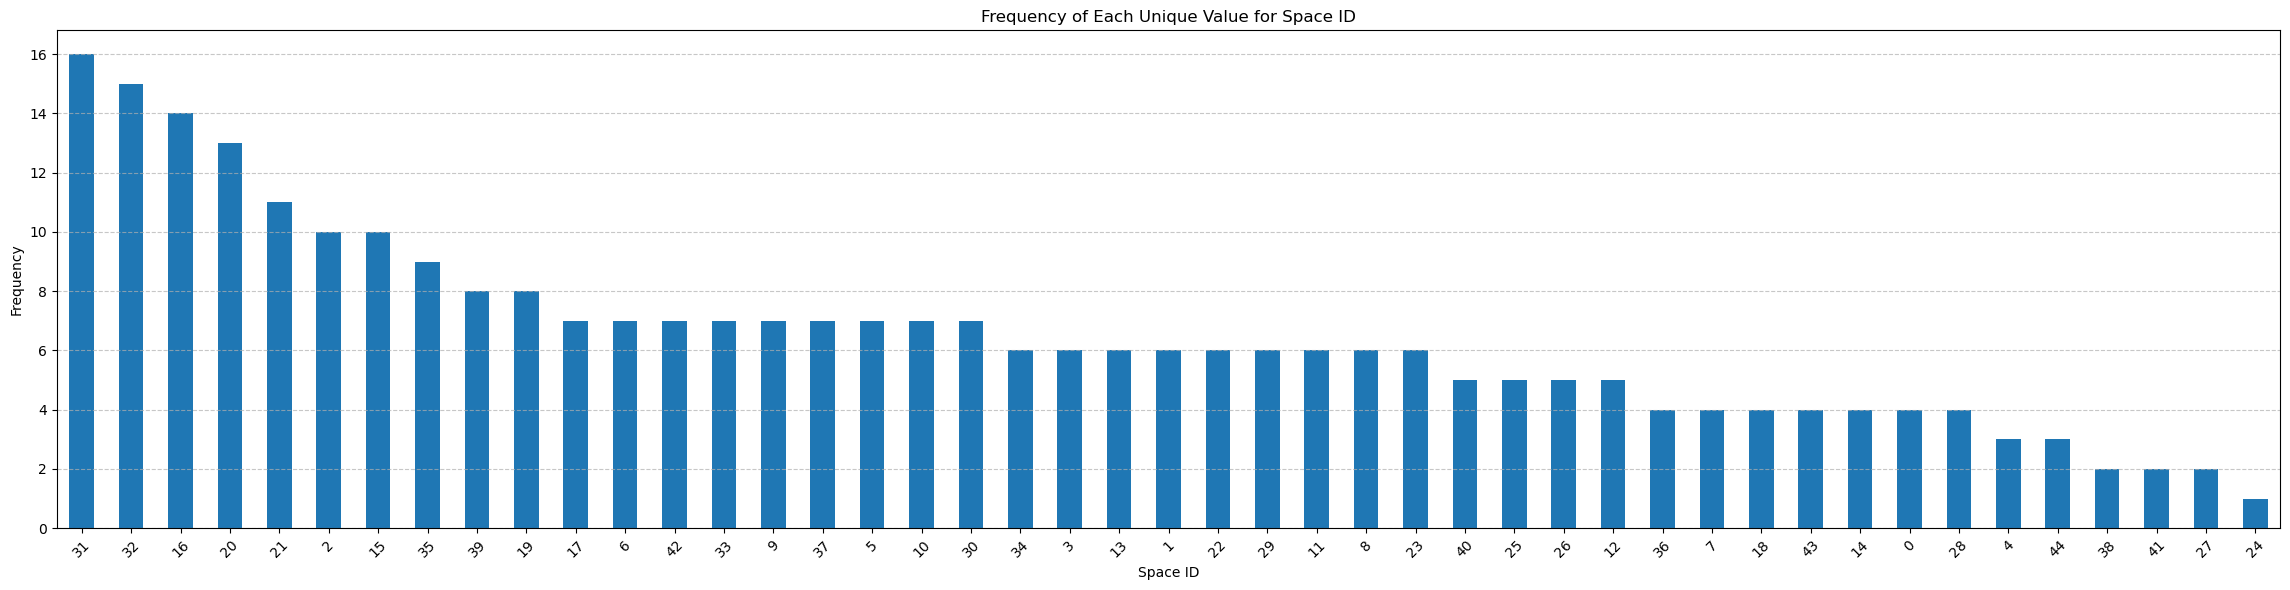

In [23]:
import matplotlib.pyplot as plt

value_counts = y_test_all_floor0.value_counts()

plt.figure(figsize=(23, 6))
value_counts.plot(kind='bar')
plt.title('Frequency of Each Unique Value for Space ID')
plt.xlabel('Space ID')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [24]:
from imblearn.over_sampling import RandomOverSampler
oversampler = RandomOverSampler()

X_resampled_floor0, y_resampled_floor0 = oversampler.fit_resample(X_test_all_floor0, y_test_all_floor0)

print(X_resampled_floor0.shape)

(720, 520)


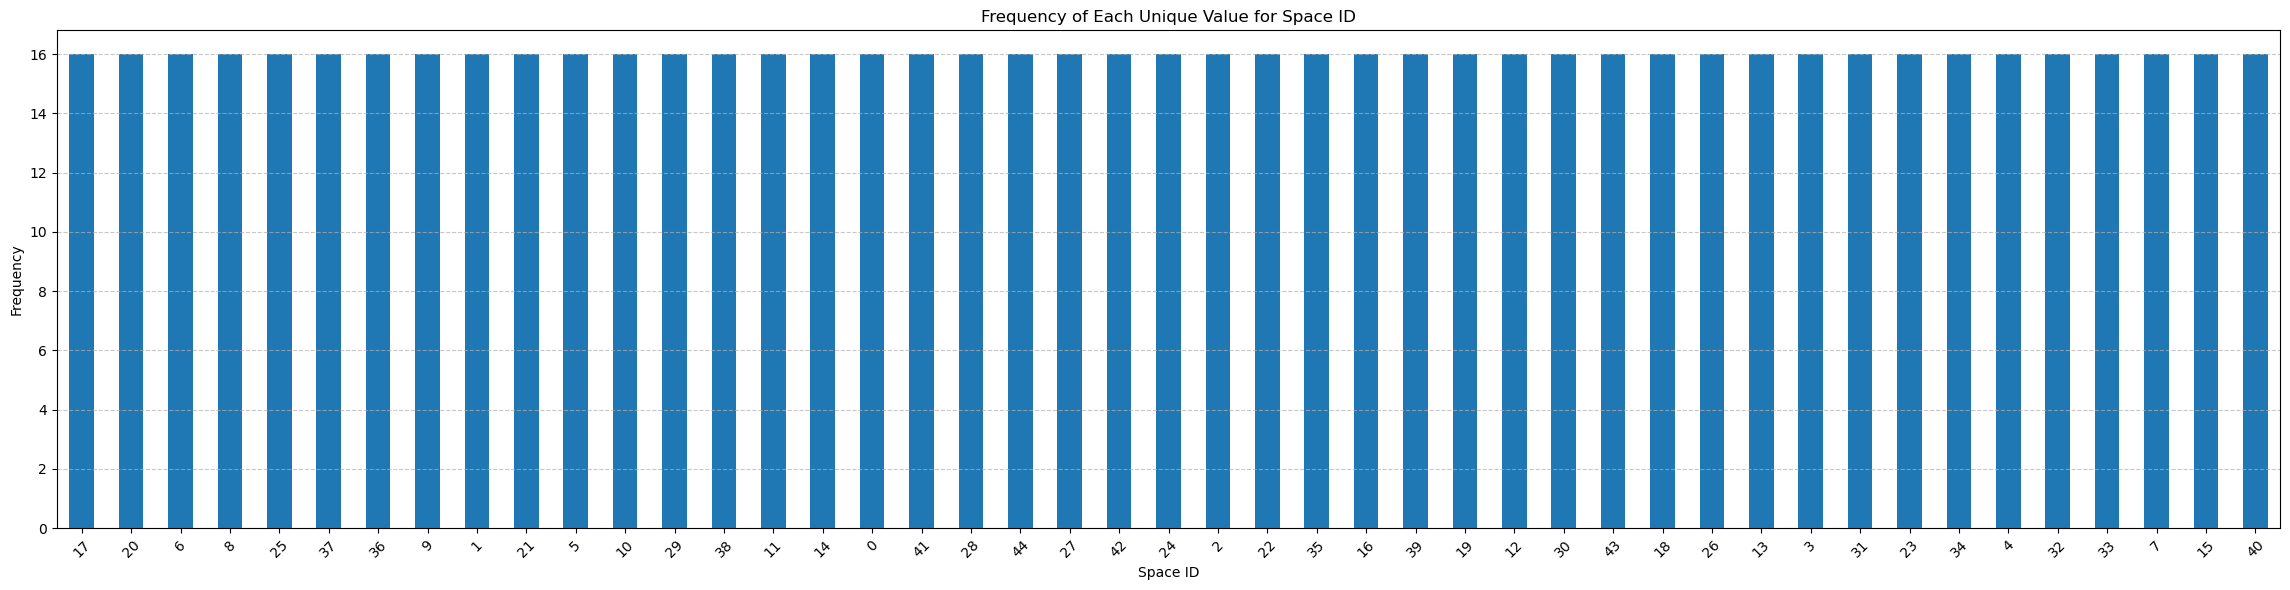

In [25]:
import matplotlib.pyplot as plt

value_counts = y_resampled_floor0.value_counts()

plt.figure(figsize=(23, 6))
value_counts.plot(kind='bar')
plt.title('Frequency of Each Unique Value for Space ID')
plt.xlabel('Space ID')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [31]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Dropout
from keras.optimizers import Adam

X_train_array = X_train_all_floor0.to_numpy()
X_test_array = X_test_all_floor0.to_numpy()

X_train_reshaped = X_train_array.reshape(X_train_array.shape[0], 1, X_train_array.shape[1])
X_test_reshaped = X_test_array.reshape(X_test_array.shape[0], 1, X_test_array.shape[1])

model = Sequential()
model.add(SimpleRNN(64, activation='relu', input_shape=(1, X_train_array.shape[1])))
model.add(Dropout(0.5))
model.add(Dense(45, activation='softmax'))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train_reshaped, y_train_all_floor0, epochs=200, batch_size=64, validation_split=0.2)

test_loss, test_accuracy = model.evaluate(X_test_reshaped, y_test_all_floor0)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

predictions = model.predict(X_test_reshaped)
predicted_spaceid_labels = np.argmax(predictions, axis=1)

for i in range(10):
    actual_spaceid_encoded = y_test_all_floor0.iloc[i]  
    predicted_spaceid = predicted_spaceid_labels[i]  
    print("Sample {}: Actual Floor: {}, Predicted Floor: {}".format(i+1, reverse_mapping[actual_spaceid_encoded], reverse_mapping[predicted_spaceid]))

Epoch 1/60


ValueError: Exception encountered when calling SimpleRNNCell.call().

[1mDimensions must be equal, but are 1 and 520 for '{{node sequential_7_1/simple_rnn_2_1/simple_rnn_cell_1/MatMul}} = MatMul[T=DT_FLOAT, grad_a=false, grad_b=false, transpose_a=false, transpose_b=false](sequential_7_1/simple_rnn_2_1/strided_slice_2, sequential_7_1/simple_rnn_2_1/simple_rnn_cell_1/Cast/ReadVariableOp)' with input shapes: [?,1], [520,64].[0m

Arguments received by SimpleRNNCell.call():
  • sequence=tf.Tensor(shape=(None, 1), dtype=float32)
  • states=('tf.Tensor(shape=(None, 64), dtype=float32)',)
  • training=True

In [27]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D
from matplotlib import pyplot as plt
X_train_all_floor0_array = X_train_all_floor0.values
X_test_all_floor0_array = X_test_all_floor0.values

model = Sequential()
model.add(Conv1D(64, 3, activation='relu', input_shape=(520, 1)))  
model.add(MaxPooling1D(2))
model.add(Conv1D(128, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Conv1D(256, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(45, activation='softmax'))  

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

X_train_all_floor0_reshaped = X_train_all_floor0_array.reshape(X_train_all_floor0_array.shape[0], X_train_all_floor0_array.shape[1], 1)
X_test_all_floor0_reshaped = X_test_all_floor0_array.reshape(X_test_all_floor0_array.shape[0], X_test_all_floor0_array.shape[1], 1)

model.fit(X_train_all_floor0_reshaped, y_train_all_floor0, epochs=60, batch_size=64, validation_split=0.2)
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()
test_loss, test_accuracy = model.evaluate(X_test_all_floor0_reshaped, y_test_all_floor0)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

predictions = model.predict(X_test_all_floor0_reshaped)
predicted_spaceid_labels = np.argmax(predictions, axis=1)

for i in range(10):
    actual_spaceid_encoded = y_test_all_floor0.iloc[i]  
    predicted_spaceid = predicted_spaceid_labels[i]  
    print("Sample {}: Actual Floor: {}, Predicted Floor: {}".format(i+1, reverse_mapping[actual_spaceid_encoded], reverse_mapping[predicted_spaceid]))


C:\Users\ASUS\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 363ms/step - accuracy: 0.0265 - loss: 3.7867 - val_accuracy: 0.0746 - val_loss: 3.5817
Epoch 2/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 299ms/step - accuracy: 0.0872 - loss: 3.5845 - val_accuracy: 0.2507 - val_loss: 3.1086
Epoch 3/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 266ms/step - accuracy: 0.1665 - loss: 3.1816 - val_accuracy: 0.3284 - val_loss: 2.5218
Epoch 4/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 303ms/step - accuracy: 0.2358 - loss: 2.8158 - val_accuracy: 0.4000 - val_loss: 2.2084
Epoch 5/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 302ms/step - accuracy: 0.2853 - loss: 2.5167 - val_accuracy: 0.4358 - val_loss: 1.9213
Epoch 6/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 289ms/step - accuracy: 0.3185 - loss: 2.2651 - val_accuracy: 0.4687 - val_loss: 1.7628
Epoch 7/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 363ms/step - accuracy: 0.3446 - loss: 2.1581 - val_accuracy: 0.4716 - val_loss: 1.6052
Epoch 8/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 321ms/step - accuracy: 0.3551 - loss: 2.0640 - val_accuracy: 

In [29]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(520,)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(45, activation='softmax'))


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train_all_floor0, y_train_all_floor0, epochs=60, batch_size=64, validation_split=0.2)

test_loss, test_accuracy = model.evaluate(X_test_all_floor0, y_test_all_floor0)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

predictions = model.predict(X_test_all_floor0)
predicted_spaceid_labels = np.argmax(predictions, axis=1)

for i in range(10):
    actual_spaceid_encoded = y_test_all_floor0.iloc[i]  
    #actual_spaceid = np.argmax(actual_spaceid_encoded)  
    predicted_spaceid = predicted_spaceid_labels[i]  
    print("Sample {}: Actual Floor: {}, Predicted Floor: {}".format(i+1, reverse_mapping[actual_spaceid_encoded], reverse_mapping[predicted_spaceid]))


Epoch 1/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.0276 - loss: 3.8016 - val_accuracy: 0.0687 - val_loss: 3.7725
Epoch 2/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0576 - loss: 3.7425 - val_accuracy: 0.0716 - val_loss: 3.6348
Epoch 3/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0889 - loss: 3.5587 - val_accuracy: 0.1104 - val_loss: 3.3121
Epoch 4/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1338 - loss: 3.2851 - val_accuracy: 0.1970 - val_loss: 2.9970
Epoch 5/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1595 - loss: 3.0511 - val_accuracy: 0.2507 - val_loss: 2.6762
Epoch 6/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1904 - loss: 2.8407 - val_accuracy: 0.3045 - val_loss: 2.4414
Epoch 7/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2388 - loss: 2.6173 - val_accuracy: 0.3552 - val_loss: 2.1747
Epoch 8/60
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2903 - loss: 2.3612 - val_accuracy: 0.4119 - va

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

rf_classifier.fit(X_train_all_floor0, y_train_all_floor0)

predicted_spaceid_labels_rf = rf_classifier.predict(X_test_all_floor0)

test_accuracy_rf = accuracy_score(y_test_all_floor0, predicted_spaceid_labels_rf)
print("Random Forest Test Accuracy:", test_accuracy_rf)

for i in range(10):
    actual_spaceid_encoded = y_test_all_floor0.iloc[i]  
    predicted_spaceid = predicted_spaceid_labels_rf[i]  
    print("Sample {}: Actual Floor: {}, Predicted Floor: {}".format(i+1, reverse_mapping[actual_spaceid_encoded], reverse_mapping[predicted_spaceid]))

Random Forest Test Accuracy: 0.9006849315068494
Sample 1: Actual Floor: 124, Predicted Floor: 124
Sample 2: Actual Floor: 103, Predicted Floor: 103
Sample 3: Actual Floor: 203, Predicted Floor: 203
Sample 4: Actual Floor: 122, Predicted Floor: 122
Sample 5: Actual Floor: 207, Predicted Floor: 207
Sample 6: Actual Floor: 126, Predicted Floor: 126
Sample 7: Actual Floor: 118, Predicted Floor: 118
Sample 8: Actual Floor: 138, Predicted Floor: 133
Sample 9: Actual Floor: 214, Predicted Floor: 214
Sample 10: Actual Floor: 125, Predicted Floor: 214


In [25]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

xgb_classifier = xgb.XGBClassifier(objective='multi:softmax', num_class=45, random_state=42)

xgb_classifier.fit(X_train_all_floor0, y_train_all_floor0)

predicted_spaceid_labels_xgb = xgb_classifier.predict(X_test_all_floor0)

test_accuracy_xgb = accuracy_score(y_test_all_floor0, predicted_spaceid_labels_xgb)
print("XGBoost Test Accuracy:", test_accuracy_xgb)

for i in range(10):
    actual_spaceid_encoded = y_test_all_floor0.iloc[i]  
    predicted_spaceid = predicted_spaceid_labels_xgb[i]  
    print("Sample {}: Actual Floor: {}, Predicted Floor: {}".format(i+1, reverse_mapping[actual_spaceid_encoded], reverse_mapping[predicted_spaceid]))

XGBoost Test Accuracy: 0.8424657534246576
Sample 1: Actual Floor: 124, Predicted Floor: 124
Sample 2: Actual Floor: 103, Predicted Floor: 103
Sample 3: Actual Floor: 203, Predicted Floor: 203
Sample 4: Actual Floor: 122, Predicted Floor: 122
Sample 5: Actual Floor: 207, Predicted Floor: 207
Sample 6: Actual Floor: 126, Predicted Floor: 126
Sample 7: Actual Floor: 118, Predicted Floor: 118
Sample 8: Actual Floor: 138, Predicted Floor: 138
Sample 9: Actual Floor: 214, Predicted Floor: 214
Sample 10: Actual Floor: 125, Predicted Floor: 214


In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_classifier = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_all_floor0, y_train_all_floor0)

print("Best Parameters:", grid_search.best_params_)
best_rf_classifier = grid_search.best_estimator_

cv_accuracy = grid_search.best_score_
print("Cross-Validation Accuracy:", cv_accuracy)

test_accuracy_best = best_rf_classifier.score(X_test_all_floor0, y_test_all_floor0)
print("Test Accuracy with Best Model:", test_accuracy_best)

Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Cross-Validation Accuracy: 0.8829135758334079
Test Accuracy with Best Model: 0.910958904109589
